#**Libary Imports**

In [ ]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install imbalanced-learn

#basic libs
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

#for data preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

#for heatmap
import seaborn as sns

#for evaluation
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#for logistic regression
from sklearn.linear_model import LogisticRegression

#for svc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV

#for random forest
from sklearn.ensemble import RandomForestClassifier

#for decision tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

#for gradient boost
from sklearn.ensemble import GradientBoostingClassifier

#for neural net
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

#for voting
from sklearn.ensemble import VotingClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


# **Data Preprocessing**

**Gather data**

In [ ]:
data = pd.read_csv('projectDataset.csv')

print("Dimensions of data:", data.shape)
data.head(5)

Dimensions of data: (4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Dataset is from https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention

It is compiled from several datasets from real institutions from various majors

In [ ]:
def plotColumnHistograms(data):
  # Create a separate histogram for each column
  for column in data.columns:
    if column != 'Target':
      #this gives the number of unique values in that column
      unique_values = data[column].unique()
      #we check if it has more than 25 unique values
      if len(unique_values) > 15:
        fig, ax = plt.subplots()
        data[column].plot(kind='density', linewidth=2, ax=ax)
        fig.suptitle(f'Histogram of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True)
        plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
        plt.show()

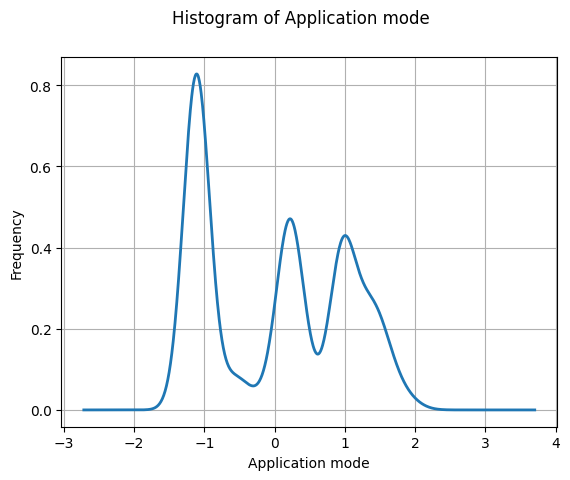

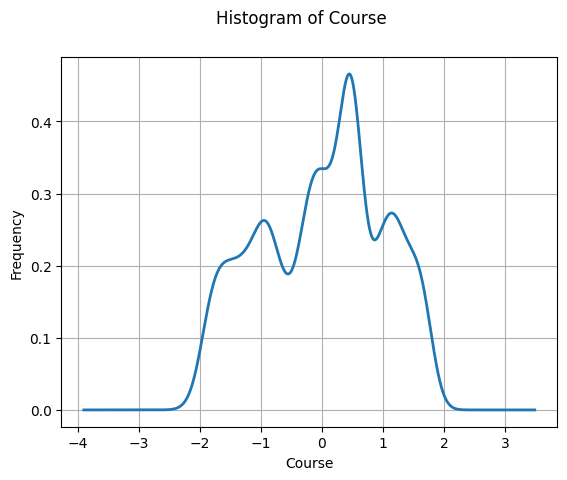

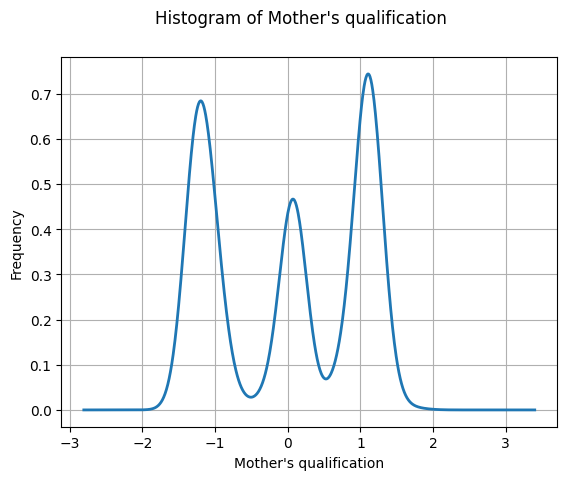

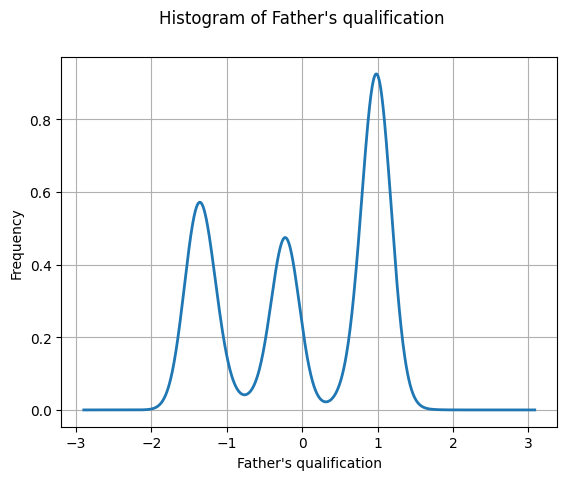

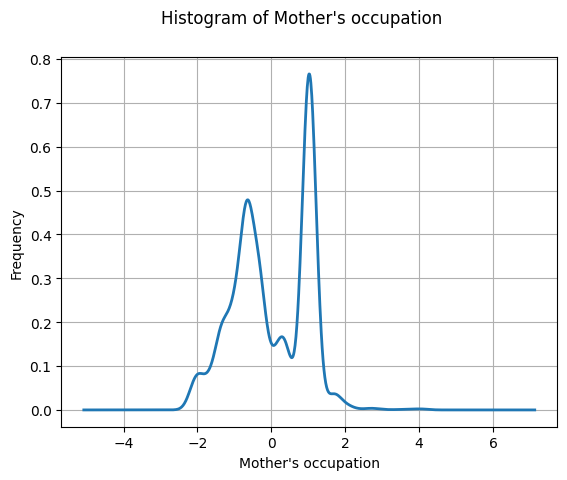

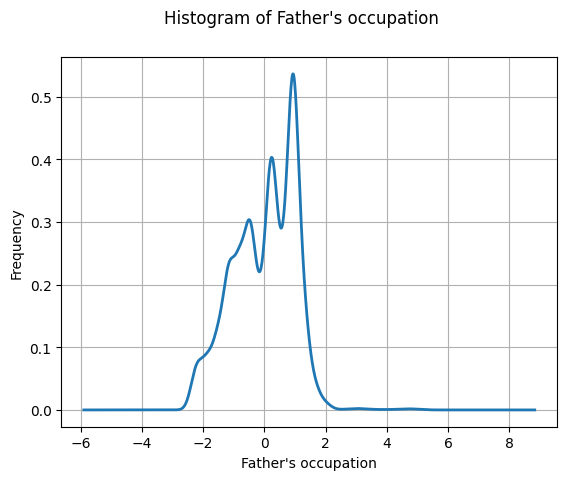

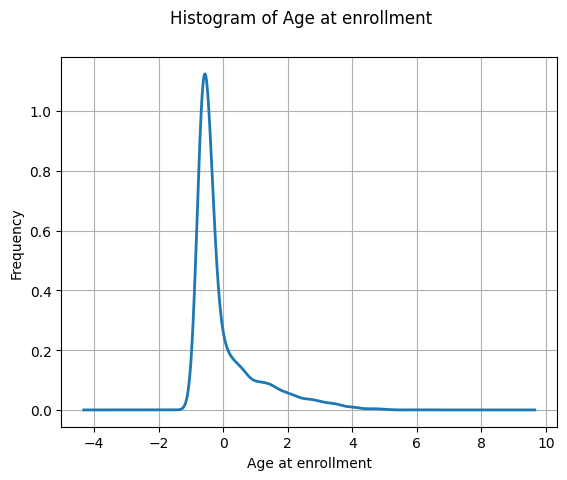

In [56]:
#plot the histograms of each features of the original data
plotColumnHistograms(data)

**Restructure data**

In [ ]:
#combine graduate and enrolled into one category
data['Target'].replace({'Graduate': 0, 'Enrolled': 0, 'Dropout': 1}, inplace=True)
print(data['Target'].unique())

unique_counts = data['Target'].value_counts()
print(unique_counts)

[1 0]
Target
0    3003
1    1421
Name: count, dtype: int64


We want to evaluate dropouts vs. non-dropouts, so we consolidated Graudate and Enrolled in class 0 and Dropout in class 1

In [ ]:
#remove features dealing with curriculum units
for col in data.columns:
  if 'Curricular units' in col:
    data.drop(col, axis=1, inplace=True)

print(f"Columns: {data.columns}")
print(f"\nData Dimensions: {data.shape}")

Columns: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Unemployment rate', 'Inflation rate', 'GDP', 'Target'],
      dtype='object')

Data Dimensions: (4424, 23)


Our goal is to predict likelihood of dropout based on demographics solely (especially for incoming students), not academic status, so we dropped grade-related columns

**Clean outliers**

In [ ]:
def cleanOutliers(data):
    count = 0

    # Iterate over each column (except the target column)
    for column in data.columns:
        if column != 'Target':
            # Calculate the correlation coefficient between the current column and the target column
            correlation_coefficient = data[column].corr(data['Target'])
            if abs(correlation_coefficient) < 0.1:
                mean = data[column].mean()
                std_dev = data[column].std()

                # Define the number of standard deviations from the mean to consider outliers
                num_std_dev = 3

                # Calculate the lower and upper bounds for outlier detection
                lower_bound = mean - (num_std_dev * std_dev)
                upper_bound = mean + (num_std_dev * std_dev)

                # Set outliers to mean for non-target columns only
                data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = mean
                count += 1

    return data, count

In [ ]:
oldRowCount = data.shape[0]
data, countOutliers = cleanOutliers(data)
print(f"{countOutliers} entries set to mean.")

15 entries set to mean.


We replace outliers to the mean for non-target columns to ensure the data properly standardizes.

Additionally, there are no null values, so we do not have to remove those

**Standardize data**

In [ ]:
def standardizeData(data):
    target_data = data['Target']
    features = data.drop(columns=['Target'])

    # Apply StandardScaler to features data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Combine scaled features and target column back together
    scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
    scaled_data['Target'] = target_data

    return scaled_data

In [ ]:
data = standardizeData(data)

We tried standardazing and normalizing data, and standardizing data yielded better results

**Split data into train and test**

In [ ]:
#split our data into features and target
X = data.drop(columns=['Target'])
y = data['Target']

#split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Display correlation heatmap**

Text(0.5, 1.0, 'Correlation Heatmap')

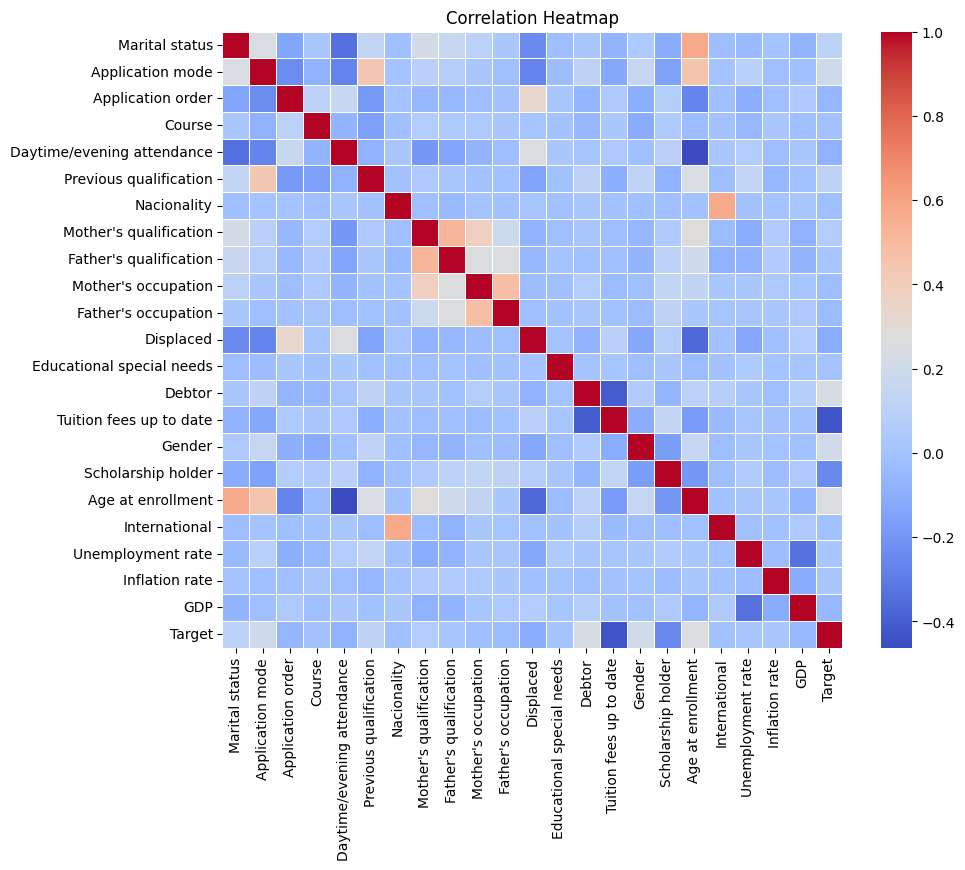

In [ ]:
#calculate correlation matrix
corr = data.corr(numeric_only=True)

#display a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')

We also experimented removing columns that had low correlation with the Target (Application mode, Debtor, Gender, Age at enrollment), but they had no difference in results. We decided to keep them

**Display final dimensions**

In [ ]:
print("Dimensions of data:", X_train.shape)
data.head(5)

Dimensions of data: (3539, 22)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Unemployment rate,Inflation rate,GDP,Target
0,-0.324247,0.210069,3.203372,-1.823744,0.350082,-0.364961,-0.092017,0.075111,-0.584526,-0.329432,...,-0.358167,0.368135,1.357640,-0.574914,-0.430363,-0.159682,-0.287638,0.124386,0.765761,1
1,-0.324247,-0.167406,-0.558559,0.254153,0.350082,-0.364961,-0.092017,-1.254495,-1.218380,-1.007535,...,-0.358167,-2.716392,1.357640,-0.574914,-0.562168,-0.159682,0.876222,-1.105222,0.347199,0
2,-0.324247,-1.111094,3.203372,-1.131112,0.350082,-0.364961,-0.092017,1.072315,0.954834,1.026776,...,-0.358167,-2.716392,1.357640,-0.574914,-0.562168,-0.159682,-0.287638,0.124386,0.765761,1
3,-0.324247,0.210069,0.381924,1.177663,0.350082,-0.364961,-0.092017,1.183116,0.954834,-0.329432,...,-0.358167,0.368135,-0.736572,-0.574914,-0.430363,-0.159682,-0.813253,-1.466871,-1.375511,0
4,3.248530,0.965018,-0.558559,-1.592866,-2.856470,-0.364961,-0.092017,1.072315,1.045384,1.026776,...,-0.358167,0.368135,-0.736572,-0.574914,2.864765,-0.159682,0.876222,-1.105222,0.347199,0


In [ ]:
print("Dimensions of data:", X_test.shape)
data.head(5)

Dimensions of data: (885, 22)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Unemployment rate,Inflation rate,GDP,Target
0,-0.324247,0.210069,3.203372,-1.823744,0.350082,-0.364961,-0.092017,0.075111,-0.584526,-0.329432,...,-0.358167,0.368135,1.357640,-0.574914,-0.430363,-0.159682,-0.287638,0.124386,0.765761,1
1,-0.324247,-0.167406,-0.558559,0.254153,0.350082,-0.364961,-0.092017,-1.254495,-1.218380,-1.007535,...,-0.358167,-2.716392,1.357640,-0.574914,-0.562168,-0.159682,0.876222,-1.105222,0.347199,0
2,-0.324247,-1.111094,3.203372,-1.131112,0.350082,-0.364961,-0.092017,1.072315,0.954834,1.026776,...,-0.358167,-2.716392,1.357640,-0.574914,-0.562168,-0.159682,-0.287638,0.124386,0.765761,1
3,-0.324247,0.210069,0.381924,1.177663,0.350082,-0.364961,-0.092017,1.183116,0.954834,-0.329432,...,-0.358167,0.368135,-0.736572,-0.574914,-0.430363,-0.159682,-0.813253,-1.466871,-1.375511,0
4,3.248530,0.965018,-0.558559,-1.592866,-2.856470,-0.364961,-0.092017,1.072315,1.045384,1.026776,...,-0.358167,0.368135,-0.736572,-0.574914,2.864765,-0.159682,0.876222,-1.105222,0.347199,0


#**Model Creation and Evaluation**

## **Evaluation setup**

In [ ]:
#declare threshold
th = 0.25

Our goal is to offer things like more tutoring services for students likely to drop out. Therefore, we chose to maximize recall of Dropout while maintaing a good accuracy to identify as many true positives as we can. We lowered threshold to 0.25 to achieve this balance.

In [ ]:
def predict_and_evaluate(classifier, threshold=th):
     y_pred = classifier.predict_proba(X_test)[:, 1]
     y_pred_threshold = (y_pred >= threshold).astype(int)
     print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_threshold))
     print("\nClassification Report:\n", classification_report(y_test, y_pred_threshold))

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color='#46e388',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#c667e0',
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

## **Logistic Regression**

**Perform hyperparameter tuning**

In [ ]:
#define model
lr_classifier = LogisticRegression(solver='liblinear', random_state=42)

#define search space
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

#run grid search and find best parameters
lr_grid_search = GridSearchCV(estimator=lr_classifier, param_grid=lr_param_grid, cv=5, n_jobs=-1)
lr_grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", lr_grid_search.best_params_)

Best Hyperparameters: {'C': 1, 'penalty': 'l2'}


**Test the final model with the best hyperparameters**

In [ ]:
#extract best model
lr_best_classifier = lr_grid_search.best_estimator_

#predict and evaluate
predict_and_evaluate(lr_best_classifier)

Confusion Matrix:
 [[382 187]
 [ 65 251]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.67      0.75       569
           1       0.57      0.79      0.67       316

    accuracy                           0.72       885
   macro avg       0.71      0.73      0.71       885
weighted avg       0.75      0.72      0.72       885



While not our very best results, these are very good results with a recall-1 of 79% and accuracy of 72%

**Plot learning curves**

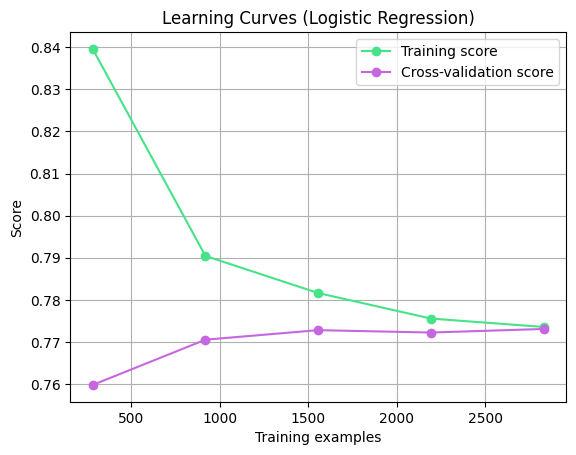

In [ ]:
plot_learning_curve(lr_best_classifier, "Learning Curves (Logistic Regression)", X_train, y_train, cv=5)

Our model converged, so there is little overfitting/underfitting which is good

## **Support Vector Classifier**

**Perform hyperparameter tuning**

In [46]:
#define model
svc_classifier = SVC(probability=True)

#define k-fold
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
rkf.get_n_splits(X_train, y_train)

#define search space
svc_param_grid = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree": [2, 3], "C": [1, 10, 100, 1000], "coef0": [0.0, 0.1, 1.0]},
    {"kernel": ["sigmoid"], "C": [1, 10, 100, 1000], "coef0": [0.0, 0.1, 1.0]},
]

#run grid search and find best parameters
svc_grid_search = RandomizedSearchCV(svc_classifier, param_distributions=svc_param_grid, n_iter=5, cv=rkf, random_state=42)
svc_grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", svc_grid_search.best_params_)

Best Hyperparameters: {'kernel': 'poly', 'degree': 2, 'coef0': 0.1, 'C': 100}


We believe we might have gotten better results with this model if we tried an exhaustive grid search, but it was taking over half a day to conduct. That's why we instead used a random grid search

**Test the final model with the best hyperparameters**

In [47]:
#extract best model
svc_best_classifier = svc_grid_search.best_estimator_ #{'kernel': 'poly', 'degree': 2, 'coef0': 0.1, 'C': 100}

#predict and evaluate
predict_and_evaluate(svc_best_classifier)

Confusion Matrix:
 [[388 181]
 [ 89 227]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74       569
           1       0.56      0.72      0.63       316

    accuracy                           0.69       885
   macro avg       0.68      0.70      0.68       885
weighted avg       0.72      0.69      0.70       885



This had some of the worst results relatively with a recall-1 of 72% and an accuracy of 69%.

**Plot learning curves**

In [ ]:
plot_learning_curve(svc_best_classifier, "Learning Curves: Support Vector Machine", X_train, y_train, cv=5)

## **Random Forest**

**Perform hyperparameter tuning**

In [ ]:
#define model
rf_classifier = RandomForestClassifier(random_state=42)

#define search space
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
}

#run grid search and find best parameters
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=rf_param_grid,cv=5, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", rf_grid_search.best_params_)

**Test the final model with the best hyperparameters**

In [ ]:
#get best model
rf_best_classifier = rf_grid_search.best_estimator_

#predict and evaluate
predict_and_evaluate(rf_best_classifier)

Confusion Matrix:
 [[390 179]
 [ 61 255]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.69      0.76       569
           1       0.59      0.81      0.68       316

    accuracy                           0.73       885
   macro avg       0.73      0.75      0.72       885
weighted avg       0.77      0.73      0.73       885



These are relatively very good results with a recall-1 of 81% and an accuracy of 73%.

**Plot learning curves**

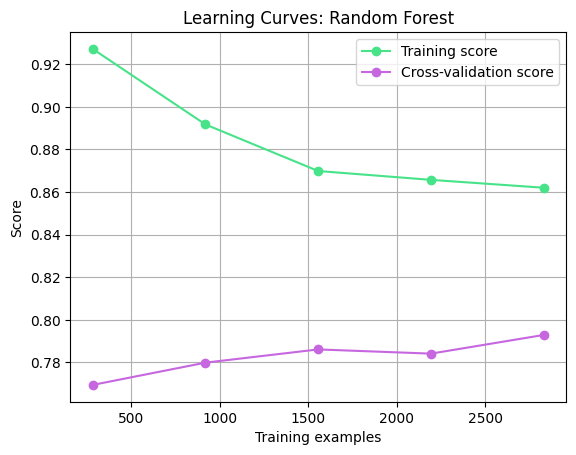

In [ ]:
plot_learning_curve(rf_best_classifier, "Learning Curves: Random Forest", X_train, y_train, cv=5)

Our model did not converge well, despite hyper-parameter tuning. The difference is 7% which is relatively not great.

## **Decision Tree**

**Perform hyperparameter tuning**

In [53]:
#define model
dt_classifier = DecisionTreeClassifier(random_state=42)

#define search space
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

#run grid search and find best parameters
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", dt_grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


**Test the final model with the best hyperparameters**

In [54]:
#extract best model
dt_best_classifier = dt_grid_search.best_estimator_

#predict and evaluate
predict_and_evaluate(dt_best_classifier)

Confusion Matrix:
 [[382 187]
 [ 55 261]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.76       569
           1       0.58      0.83      0.68       316

    accuracy                           0.73       885
   macro avg       0.73      0.75      0.72       885
weighted avg       0.77      0.73      0.73       885



This had the best results relatively with a recall-1 of 83% and an accuracy of 73%.

**Plot learning curves**

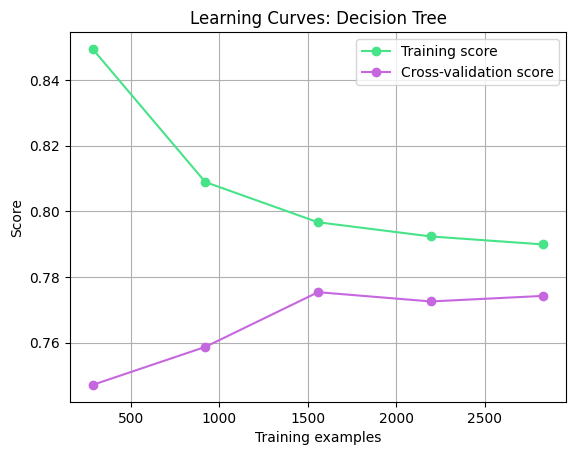

In [55]:
plot_learning_curve(dt_best_classifier, "Learning Curves: Decision Tree", X_train, y_train, cv=5)

Our model did not converge completely, despite hyper-parameter tuning. However, this difference is only 2% so it is not that much.

## **Gradient Boost**

**Perform hyperparameter tuning**

In [ ]:
#define model
gb_classifier = GradientBoostingClassifier(random_state=42)

#define seach space
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

#run grid search and find best parameters
gb_grid_search = GridSearchCV(estimator=gb_classifier, param_grid=gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", gb_grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


**Test the final model with the best hyperparameters**

In [ ]:
#extract best model
gb_best_classifier = gb_grid_search.best_estimator_

#predict and evaluate
predict_and_evaluate(gb_best_classifier)

Confusion Matrix:
 [[400 169]
 [ 79 237]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76       569
           1       0.58      0.75      0.66       316

    accuracy                           0.72       885
   macro avg       0.71      0.73      0.71       885
weighted avg       0.75      0.72      0.73       885



This had some of the worst results relatively with a recall-1 of 75% and an accuracy of 72%.

**Plot learning curves**

In [ ]:
plot_learning_curve(gb_best_classifier, "Learning Curves: Gradient Boost", X_train, y_train, cv=5)

## **Neural Network**

**Define model**

In [ ]:
def create_model(neurons=100, layers=2, act_h='relu', act_o='sigmoid', dropout=0.0, input_dim=None):
    model = Sequential()

    #input layer
    model.add(Dense(neurons, input_dim=input_dim, activation=act_h))
    model.add(Dropout(dropout))

    #hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation=act_h))
        model.add(Dropout(dropout))

    #output layer
    model.add(Dense(1, activation=act_o))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

**Perform hyperparameter tuning**

In [ ]:
#define model
nn_classifier = KerasClassifier(build_fn=create_model, input_dim=X_train.shape[1], epochs=70, batch_size=200)

#define search space
nn_param_grid = {
    'neurons': [25, 50, 75, 100],
    'layers': [x+2 for x in range(4)],
    'act_h': ['relu', 'sigmoid', 'tanh', 'leakyrelu'],
    'act_o': ['sigmoid'],
    'dropout': [0.0, 0.2]
}

#run grid search
nn_grid_search = GridSearchCV(estimator=nn_classifier, param_grid=nn_param_grid, n_jobs=-1, cv=8)
grid_nn_grid_search_result = nn_grid_search.fit(X_train, y_train)

#summarize results
print("Best: %f using %s" % (grid_nn_grid_search_result.best_score_, grid_nn_grid_search_result.best_params_))
means = grid_nn_grid_search_result.cv_results_['mean_test_score']
stds = grid_nn_grid_search_result.cv_results_['std_test_score']
params = grid_nn_grid_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#extract best parameters
nn_best_params = grid_nn_grid_search_result.best_params_
print("Best Hyperparameters:", nn_best_params)

<ipython-input-33-1dc8dc1eea84>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_classifier = KerasClassifier(build_fn=create_model, input_dim=X_train.shape[1], epochs=70, batch_size=200)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
256 fits failed out of a total of 1024.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-------------------------------------------------

Epoch 1/70
18/18 [==============================] - 2s 4ms/step - loss: 0.6383 - accuracy: 0.6363
Epoch 2/70
18/18 [==============================] - 0s 3ms/step - loss: 0.5360 - accuracy: 0.7383
Epoch 3/70
18/18 [==============================] - 0s 4ms/step - loss: 0.5147 - accuracy: 0.7545
Epoch 4/70
18/18 [==============================] - 0s 4ms/step - loss: 0.5008 - accuracy: 0.7660
Epoch 5/70
18/18 [==============================] - 0s 3ms/step - loss: 0.4996 - accuracy: 0.7663
Epoch 6/70
18/18 [==============================] - 0s 4ms/step - loss: 0.4974 - accuracy: 0.7686
Epoch 7/70
18/18 [==============================] - 0s 3ms/step - loss: 0.4996 - accuracy: 0.7706
Epoch 8/70
18/18 [==============================] - 0s 4ms/step - loss: 0.4973 - accuracy: 0.7720
Epoch 9/70
18/18 [==============================] - 0s 3ms/step - loss: 0.4956 - accuracy: 0.7703
Epoch 10/70
18/18 [==============================] - 0s 4ms/step - loss: 0.4938 - accuracy: 0.7666
Epoch 11/70
18/18 [

**Test the final model with the best hyperparameters**

In [ ]:
#define model with best hyperparameters
nn_best_classifier = create_model(neurons=nn_best_params['neurons'], layers=nn_best_params['layers'],
                          act_h=nn_best_params['act_h'], act_o=nn_best_params['act_o'],
                          dropout=nn_best_params['dropout'], input_dim=X_train.shape[1])

#train model
nn_best_classifier.fit(X_train, y_train)

#predict
y_pred_proba = nn_best_classifier.predict(X_test)

#apply threshold
y_pred = (y_pred_proba > th).astype(int)

#convert to binary format
y_test_binary = (y_test > 0.5).astype(int)

#evaluate
print("\nConfusion Matrix:\n", confusion_matrix(y_test_binary, y_pred))
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred))

28/28 [==============================] - 0s 2ms/step

Confusion Matrix:
 [[394 175]
 [ 80 236]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.76       569
           1       0.57      0.75      0.65       316

    accuracy                           0.71       885
   macro avg       0.70      0.72      0.70       885
weighted avg       0.74      0.71      0.72       885



This did moderately with a recall-1 of 75% and an accuracy of 71%.

## **Voting Classifier**

**Define model**

In [48]:
#create list of base classifiers
classifiers = [('Logistic Regression', lr_best_classifier),
               ('Support Vector', svc_best_classifier),
               ('Random Forest', rf_best_classifier),
               ('Decision Tree', dt_best_classifier),
               ('Gradient Boost', gb_best_classifier)]

#define model
voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')

#train
voting_classifier.fit(X_train, y_train)

#predict and evaluate
predict_and_evaluate(voting_classifier)

Confusion Matrix:
 [[389 180]
 [ 58 258]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.77       569
           1       0.59      0.82      0.68       316

    accuracy                           0.73       885
   macro avg       0.73      0.75      0.73       885
weighted avg       0.77      0.73      0.74       885



This had some of the best results relatively with a recall-1 of 82% and an accuracy of 73%.

**Plot learning curves**

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


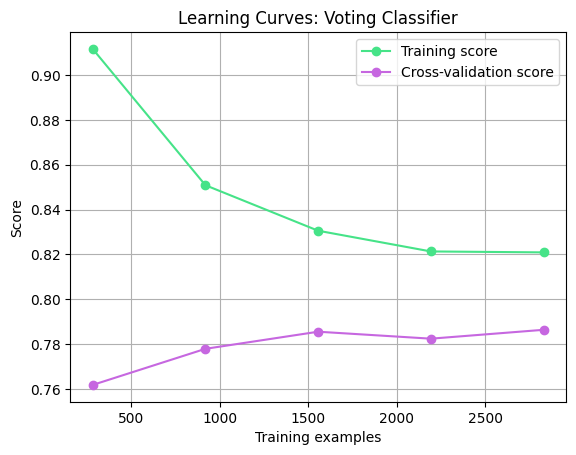

In [49]:
plot_learning_curve(voting_classifier, "Learning Curves: Voting Classifier", X_train, y_train, cv=5)

Our model did not converge completely, despite hyper-parameter tuning. However, this difference is only 4% so it is not that much.

# **Overall Evaluation**

**Statistical Analysis**

Overall, our best models in terms of the classification report (with a focus on recall-1 and accuracy to determine true dropouts) were random forest, decision tree, and voting classifier with a recall-1 of 81-83% and accuracy of 73%. We decided our best model is **decision tree** because it had the highest recall-1 and accuracy.

However, our decision tree model has aboout a 2% difference in the learning curves, meaning there could be a little overfitting. Our next best model is  **logistic regression** because it had a close recall-1 of 79% and accuracy of 72% while being able to converge.

All our models had very similar precision-1 of 56-59% and recall-0 of 67-70%. Unfortunately, all of our models besides logistic regression (and neural network, which we could not use our plot_learning_curve function on) did not converge.

**Final Thoughts**

Classifying more students as Dropout, regardless true or not, allows vulnerable students to receive help. While each of our models misclassified around 180 of 569 (31%) non-dropouts as droupouts, these students might also be vulnerable to dropping out and may also need assistance such as tutoring that students who will dropout would receive.

Very high accuracies would be devastating. If we could 100% predict if a student will drop out, then there's no point of these students to start college in the first place. Our focus is to find students who are likely to drop out based on demographics so they can overcome these obstacles and prove these results wrong. This is already the case for some students in the real world.

We could next try to improve results with more data or advanced feature engineering techniques so they can converge.

Future work would include students’ academics, mental health, etc. While demographics play a significant role of students' success in college, a lot can change from when they start college.